In [90]:
from maap.maap import MAAP
maap = MAAP(maap_host='api.ops.maap-project.org')

# Launch DPS for 3.1.2_dps.py
multi-spectral composites


In [91]:
from os import path
import os, glob
import datetime
import pandas as pd
import geopandas as gpd
!pip install -U -r /projects/Developer/icesat2_boreal/dps/requirements_main.txt
!pip install xmltodict

import xmltodict
import sys
sys.path.append('/projects/Developer/icesat2_boreal/lib')
import ExtractUtils
import matplotlib
import maplib_folium

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## Use the tag set up for this algorithm
#### Commit with Tag for running
1) Add version name as a map_boreal_2022_v2 or whatever is appropriate - both to this notebook and algorithm config yaml

2) follow git instructions (every time!!):  
git add changes  
git commit -m 'message'  
git tag -f <tag_name>  

git push  
git push dps  
git push origin -f map_boreal_2022_v2  
git push dps -f map_boreal_2022_v2  

3) if it looks weird check git log to make sure tag is at same place as origin and dps

# Register DPS algorithm
We need to register a DPS algorithm called 'do_HLS_stack_3-1-2' before proceeding to the chunks below...

In [88]:
!python /projects/register-algorithm /projects/Developer/icesat2_boreal/dps/alg_3-1-2/algorithm_config.yaml

{
  "algorithm_name": "do_HLS_stack_3-1-2",
  "code_version": "HLS_stack_2022_v2",
  "environment_name": "ubuntu",
  "repo_url": "https://repo.ops.maap-project.org/icesat2_boreal/icesat2_boreal.git",
  "docker_container_url": "mas.dit.maap-project.org/root/maap-workspaces/base_images/vanilla:dit",
  "queue": "maap-dps-worker-16gb",
  "algorithm_description": "DPS run to create tiled HLS composites",
  "build_command": "icesat2_boreal/dps/build_command_main.sh",
  "script_command": "icesat2_boreal/dps/alg_3-1-2/run.sh",
  "disk_space": "16GB",
  "algorithm_params": [
    {
      "field": "in_tile_fn",
      "download": true
    },
    {
      "field": "in_tile_num",
      "download": false
    },
    {
      "field": "in_tile_layer",
      "download": false
    },
    {
      "field": "sat_api",
      "download": false
    },
    {
      "field": "tile_buffer_m",
      "download": false
    },
    {
      "field": "start_year",
      "download": false
    },
    {
      "field": "end_ye

# Show status of MS composites for boreal tiles: find tiles still NEEDED
    Colored tiles indicate those still needed - water tiles removed
    BLACK tiles are processed

In [208]:
RUN_ALL_TILES = True

if False:
    !python /projects/Developer/icesat2_boreal/lib/build_tindex_master.py -t HLS -y 2022 -m_list 03 04 05

HLS_EXISTING_TINDEX_FN = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS_tindex_master.csv' #'/projects/shared-buckets/nathanmthomas/DPS_tile_lists/HLS_tindex_master.csv'

if RUN_ALL_TILES:
    print('Running DPS on a ALL tiles from a previous tindex')
    hls_tindex_master = pd.read_csv(HLS_EXISTING_TINDEX_FN)
    HLS_TILES_NEEDED = hls_tindex_master.tile_num.to_list()
        
    print(f"List length: {len(HLS_TILES_NEEDED)}")
else:
    HLS_TILES_NEEDED = ExtractUtils.GET_TILES_NEEDED(DPS_DATA_TYPE = 'HLS', tindex_master_fn = HLS_EXISTING_TINDEX_FN)
    #HLS_TILES_NEEDED = GET_TILES_NEEDED(DPS_DATA_TYPE = 'HLS', FIND_TILE_GROUP = 'north america west', tindex_master_fn = '/projects/shared-buckets/nathanmthomas/DPS_tile_lists/HLS_tindex_master.csv')

Running DPS on a ALL tiles from a previous tindex
List length: 5245


In [36]:
INPUT_TILE_NUM_LIST = HLS_TILES_NEEDED
len(INPUT_TILE_NUM_LIST)

5245

#### Search for tiles that need to be redone due to artifacts
    + artifacts are scene-induced - where max_cloud = 25 was a bit too harsh
    + manually specify a redo tiles list after inspecting MS comps
    + delete the existing tile dirs for those tiles

In [37]:
if not RUN_ALL_TILES:
    REDO_TILES = [
                    1043, 1044, \
                    34675, 34674, 34676, 35126, 35125, 35352, 1216,
                    3193, 3286, 3380, 3938, 3949
                 ]

    REDO_TILES = [3090, 3833, 3920, 701, 747, 35577, 34443, 3949, 1044, 3470]
    # Get the tindex of the REDOs
    redo_hls_tindex = GET_TILES_NEEDED(DPS_DATA_TYPE = 'HLS', REDO_TILES_LIST = REDO_TILES)

    if False:
        # Delete the tile dirs of the tiles needing a REDO
        for file in redo_hls_tindex.local_path.to_list():
            p = os.path.split(file)[0]
            print(p)
            !rm -rf $p
            
    INPUT_TILE_NUM_LIST = REDO_TILES
    print(INPUT_TILE_NUM_LIST)

In [38]:
DO_EXPERIMENT = False

In [39]:
if DO_EXPERIMENT:
    
    NORWAY_TILE_LIST = pd.read_csv('/projects/shared-buckets/lduncanson/misc_files/norway_tiles.csv').layer.tolist()

    DELTA_TILE_LIST = [3365,3366,3367,3458,3459,3460,3353,3354,3355] + [3361, 3362]
    BONA_TILE_LIST  = [3270,3271,3272, 3456,3457,  3363,3364,3365] + [3268, 3269]
    HEALY_TILE_LIST = [ 3551,3552,3553,3645,3646,3647] + [3648, 3649, 3555, 3554]

    #DELTA_TILE_LIST = [3365,3366,3367,3458,3460,3353,3354,3355,3549]
    #BONA_TILE_LIST  = [3270,3271,3272,3364,3456,3457,3458,3364,3365]
    #HEALY_TILE_LIST = [3456,3457,3458,3551,3552, 3553,3645,3646,3647]
    INPUT_EXPERIMENT_TILE_NUM_LIST = NORWAY_TILE_LIST + DELTA_TILE_LIST + BONA_TILE_LIST + HEALY_TILE_LIST
    ALASKA_TILE_LIST =  list(range(3268,3272+1))+\
                        list(range(3361,3366+1))+\
                        list(range(3454,3459+1))+\
                        list(range(3549,3555+1))+\
                        list(range(3643,3648+1))

    INPUT_EXPERIMENT_TILE_NUM_LIST = NORWAY_TILE_LIST + ALASKA_TILE_LIST
    len(INPUT_EXPERIMENT_TILE_NUM_LIST)

In [40]:
if DO_EXPERIMENT:
    
    ILAB_AK_TILE = [3000]
    KENAI_TILE = [4017]
    ARY_MAS_TILE = [37744, 37743, 37742]
    NRWY_TILE = [131]
    SESIB_TILE = [3421]
    HOWLAND_TILE = [34210]
    BC_TILES = list(range(3846,3868+1)) 
    MISC_TILES = ARY_MAS_TILE + ILAB_AK_TILE + KENAI_TILE + HOWLAND_TILE + BC_TILES + SESIB_TILE# + NRWY_TILE
    print(len(MISC_TILES))
    
    print(len(MISC_TILES + INPUT_EXPERIMENT_TILE_NUM_LIST))
    
    DPS_INPUT_TILE_NUM_LIST = HOWLAND_TILE + ARY_MAS_TILE
    print(len(DPS_INPUT_TILE_NUM_LIST))
    

In [41]:
# A strip across Siberia that can be improved with shorter seaonal window and broader cloud threshold?
if DO_EXPERIMENT:
    MISC_TILES = []
    INPUT_EXPERIMENT_TILE_NUM_LIST = list(range(1620,1657 + 1))
    print(len(INPUT_EXPERIMENT_TILE_NUM_LIST))

In [59]:
if DICT_RUN_NAME_TIME is None:
    DICT_RUN_NAME_TIME = dict()#.fromkeys([RUN_NAME])
DICT_RUN_NAME_TIME

{'mc25_06-01_09-15_2019_2021': '202210181636'}

# Run a DPS of MS Composite tiles

In [130]:
#DPS_INPUT_TILE_NUM_LIST = DPS_INPUT_TILE_NUM_LIST[2000:2100]
# 'mc40_06-01_09-15_2019_2021'
# 25_06-15_09-01_2019_2021
# 25_06-01_09-15_2019_2021
# 35_06-15_09-01_2019_2021
# 40_07-01_09-01_2019_2021
# 50_06-01_09-15_2019_2021      19
# 50_06-15_09-01_2019_2021
# 50_06-15_09-15_2019_2021
# 10_07-01_09-01_2019_2021
# 0_06-01_09-15_2019_2021
# '40_06-01_09-15_2019_2021' 
# 25_06-15_09-01_2019_2021 
# 35_06-15_09-01_2019_2021
# 50_06-15_09-01_2019_2021 50_06-15_09-01_2019_2021
# 40_06-01_09-15_2019_2021 40_06-01_09-15_2019_2021
MAX_CLOUDS = 30
SEASON_START = '06-15'
SEASON_STOP = '09-01'
YEAR_START = '2019'
YEAR_STOP = '2021'
RUN_NAME = f'mc{MAX_CLOUDS}_{SEASON_START}_{SEASON_STOP}_{YEAR_START}_{YEAR_STOP}'

RUN_NAME


'mc30_06-15_09-01_2019_2021'

### Re-run this batch with same tile-specific composite params as spring2022


In [115]:
DO_MATCH_PREVIOUS_PARAMS = True

In [116]:
TEST_DPS  = False

if TEST_DPS:
    print('Running DPS on a SUBSET list of input')
    DPS_INPUT_TILE_NUM_LIST = INPUT_TILE_NUM_LIST[-10:]
else:
    if DO_MATCH_PREVIOUS_PARAMS:
        print('Running DPS on the subset list with matched params')
        OUTPUT_FN = '/projects/my-public-bucket/DPS_tile_lists/HLS_test_redo/spring2022/HLS_input_params.csv'
        df = pd.read_csv(OUTPUT_FN)
        DPS_INPUT_TILE_NUM_LIST = df[(df.max_cloud == MAX_CLOUDS) & 
                       (df.start_month_day ==SEASON_START) & 
                       (df.end_month_day == SEASON_STOP)
                      ].in_tile_num.to_list()
    elif DO_EXPERIMENT:
        print('Running DPS on the FULL list of EXPERIMENT input')
        DPS_INPUT_TILE_NUM_LIST = MISC_TILES + INPUT_EXPERIMENT_TILE_NUM_LIST
    else:
        print('Running DPS on the FULL list of input')
        DPS_INPUT_TILE_NUM_LIST = INPUT_TILE_NUM_LIST
    
print(f"List length: {len(DPS_INPUT_TILE_NUM_LIST)}")

Running DPS on the subset list with matched params
List length: 2225


In [131]:
%%time
submit_results_df_list = []
len_input_list = len(DPS_INPUT_TILE_NUM_LIST)
print(f"# of input tiles for DPS: {len_input_list}")

for i, INPUT_TILE_NUM in enumerate(DPS_INPUT_TILE_NUM_LIST):

    DPS_num = i+1
    IDENTIFIER = "do_HLS_stack_3-1-2"
    ALGO_ID = f'{IDENTIFIER}_ubuntu'
    USER = 'nathanmthomas'
    WORKER_TYPE = 'maap-dps-worker-32gb'
    
    in_param_dict = {
                         'in_tile_fn': 'https://maap-ops-workspace.s3.amazonaws.com/shared/nathanmthomas/boreal_tiles_v003.gpkg',
                         'in_tile_num': INPUT_TILE_NUM,
                         'in_tile_layer': 'boreal_tiles_v003',
                         'sat_api': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD',
                        #'sat_api': 'https://landsatlook.usgs.gov/sat-api',
                         'tile_buffer_m': 0,
                         'start_year': YEAR_START,
                         'end_year': YEAR_STOP,
                         'start_month_day': SEASON_START,
                         'end_month_day': SEASON_STOP,
                         'max_cloud': MAX_CLOUDS,
                         'composite_type': 'HLS'
        }
        
    submit_result = maap.submitJob(
                                    identifier=IDENTIFIER,
                                    algo_id=ALGO_ID,
                                    version="HLS_stack_2022_v2", 
                                    username=USER,
                                    queue=WORKER_TYPE,
                                    # Args that match yaml
                                    **in_param_dict
        )
    
    # Build a dataframe of submission details
    submit_result['dps_num'] = DPS_num
    submit_result['tile_num'] = INPUT_TILE_NUM
    submit_result['submit_time'] = datetime.datetime.now()
    submit_result['dbs_job_hour'] =datetime.datetime.now().hour
    submit_result['algo_id'] = ALGO_ID
    submit_result['user'] = USER
    submit_result['worker_type'] = WORKER_TYPE

    # Append to a list of data frames of submission results
    submit_results_df_list.append(pd.DataFrame([submit_result]))
    
    if DPS_num in [1, 25,50, 100,200,300,400,500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 5000, 7000, 9000, 11000, 13000, 15000, 17000, 19000, 21000, 24000, len_input_list]:
        print(f"DPS run #: {DPS_num}\t| tile num: {INPUT_TILE_NUM}\t| submit status: {submit_result['status']}\t| job id: {submit_result['job_id']}") 
        
# Build a final submission results df and save
submit_results_df = pd.concat(submit_results_df_list)
submit_results_df['run_name'] = RUN_NAME
nowtime = pd.Timestamp.now().strftime('%Y%m%d%H%M')
print(f"Current time:\t{nowtime}")
submit_results_df.to_csv(f'/projects/my-public-bucket/dps_submission_results/DPS_{IDENTIFIER}_submission_results_{len_input_list}_{nowtime}.csv')
submit_results_df

# of input tiles for DPS: 1
DPS run #: 1	| tile num: 2490	| submit status: success	| job id: bbbc7f8f-c11d-44d6-9cb0-642fa908bd4b
Current time:	202210211929
CPU times: user 19.6 ms, sys: 0 ns, total: 19.6 ms
Wall time: 411 ms


,status,http_status_code,job_id,dps_num,tile_num,submit_time,dbs_job_hour,algo_id,user,worker_type,run_name
0,success,200,bbbc7f8f-c11d-44d6-9cb0-642fa908bd4b,1,2490,2022-10-21 19:29:33.203702,19,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc30_06-15_09-01_2019_2021


After almost any DPS job, you have to assess what succeeded and failed. This involves:
1. building a table of job status based on job ids captured in the job_results_df from the DPS run chunk (this takes 40 mins for ~47k jobs) --> this tells you how many jobs failed
2. merging the job status table with the job results df --> this tells you which specific granules (or tile nums) failed
3. building another input list of granules for a follow-up DPS
## Assess DPS results
Build a table of job status based on job id - how many jobs failed?

#### Update the dict of DPS runs to monitor success and fails

In [31]:
if False:
    DICT_RUN_NAME_TIME = dict()

In [132]:
DICT_RUN_NAME_TIME.update([(RUN_NAME, nowtime)])

In [133]:
for DICT_RUN_NAME, DPS_DATETIME in DICT_RUN_NAME_TIME.items():
    print(DICT_RUN_NAME, DPS_DATETIME)

mc40_06-01_09-15_2019_2021 202210211213
mc50_06-15_09-01_2019_2021 202210211712
mc35_06-15_09-01_2019_2021 202210211719
mc30_06-15_09-01_2019_2021 202210211929


In [134]:
if False:
    IDENTIFIER = "do_HLS_stack_3-1-2"

    DICT_RUN_NAME_TIME = {
        'mc25_06-01_09-15_2019_2021': '202210181636',
     'mc35_06-15_09-01_2019_2021': '202210201317',
     'mc40_07-01_09-01_2019_2021': '202210181804',
     'mc50_06-01_09-15_2019_2021': '202210181816',
     'mc50_06-15_09-01_2019_2021': '202210201319',
     'mc50_06-15_09-15_2019_2021': '202210181830',
     'mc10_07-01_09-01_2019_2021': '202210181932',
        'mc0_06-01_09-15_2019_2021': '202210191948', 
        'mc40_06-01_09-15_2019_2021' : '202210201322',
        'mc25_06-15_09-01_2019_2021': '202210201333'
    }

In [149]:
%%time
LIST_SUBMISSIONS = sorted(glob.glob(f'/projects/my-public-bucket/dps_submission_results/DPS_{IDENTIFIER}_submission_results_*.csv'),key=ExtractUtils.func, reverse=True)
#for DPS_DATETIME in [nowtime]:
fails_list = []
for DICT_RUN_NAME, DPS_DATETIME in DICT_RUN_NAME_TIME.items():
    for fn in LIST_SUBMISSIONS:
        if DPS_DATETIME in fn and not 'job_status' in fn:
            DPS_alg_id = os.path.basename(fn.split('_submission_results_')[0].replace('DPS_',''))
            thentime = fn.split('_')[-1].replace('.csv','')
            print(f'DPS alg:\t\t{DPS_alg_id}')
            print(f'DPS run name:\t\t{DICT_RUN_NAME}')
            print(f'DPS launch time:\t{thentime}')
            z = ExtractUtils.BUILD_TABLE_JOBSTATUS(pd.read_csv(fn))
            # Save job status table
            z.to_csv(f'/projects/my-public-bucket/dps_submission_results/DPS_{IDENTIFIER}_submission_results_job_status_{len(z)}_{thentime}.csv')

            # Get fails df and append to list
            z['run_type'] = DICT_RUN_NAME
            fails_list.append(z[z['wps:Status'] =='Failed'])
df_all_fails = pd.concat(fails_list)

DPS alg:		do_HLS_stack_3-1-2
DPS run name:		mc40_06-01_09-15_2019_2021
DPS launch time:	202210211213
Count total jobs:	3
Count pending jobs:	0
Count running jobs:	0
Count succeeded jobs:	3
Count failed jobs:	0
% of failed jobs:	Nothing has failed...yet

DPS alg:		do_HLS_stack_3-1-2
DPS run name:		mc50_06-15_09-01_2019_2021
DPS launch time:	202210211712
Count total jobs:	2
Count pending jobs:	0
Count running jobs:	0
Count succeeded jobs:	2
Count failed jobs:	0
% of failed jobs:	Nothing has failed...yet

DPS alg:		do_HLS_stack_3-1-2
DPS run name:		mc35_06-15_09-01_2019_2021
DPS launch time:	202210211719
Count total jobs:	1
Count pending jobs:	0
Count running jobs:	0
Count succeeded jobs:	0
Count failed jobs:	1
% of failed jobs:	100.0

DPS alg:		do_HLS_stack_3-1-2
DPS run name:		mc30_06-15_09-01_2019_2021
DPS launch time:	202210211929
Count total jobs:	1
Count pending jobs:	0
Count running jobs:	0
Count succeeded jobs:	1
Count failed jobs:	0
% of failed jobs:	Nothing has failed...yet

CPU

### Get a list of the FAILS to run through DPS again
#### Build a dict of the list of fails for each run name

In [166]:
TILE_FAILS_DICT = dict()
for name, group in df_all_fails.groupby('run_name'):
    TILE_FAILS_DICT.update([(name, group.tile_num.to_list())])

In [167]:
DPS_INPUT_TILE_NUM_LIST = TILE_FAILS_DICT['mc25_06-15_09-01_2019_2021']
len(DPS_INPUT_TILE_NUM_LIST)

2

In [127]:
#DPS_INPUT_TILE_NUM_LIST = z[z['wps:Status'] =='Failed'].tile_num.to_list()#[0:20]
#len(DPS_INPUT_TILE_NUM_LIST)

#pd.DataFrame({'tile_num': DPS_INPUT_TILE_NUM_LIST}).to_csv('/projects/my-public-bucket/dps_submission_results/tmp_tile_list.csv')
#z[z['wps:Status'] =='Failed']

### Look at the error log an an index location of a failed job

In [137]:
INDEX_LOC =0
#xmltodict.parse(maap.getJobResult(z[z['wps:Status'] =='Failed'].iloc[INDEX_LOC].job_id).content)
xmltodict.parse(maap.getJobResult(df_all_fails.iloc[INDEX_LOC].job_id).content)

{'wps:Result': {'@xmlns:ows': 'http://www.opengis.net/ows/2.0',
  '@xmlns:schemaLocation': 'http://schemas.opengis.net/wps/2.0/wps.xsd',
  '@xmlns:wps': 'http://www.opengis.net/wps/2.0',
  '@xmlns:xsi': 'http://www.w3.org/2001/XMLSchema-instance',
  'wps:JobID': '2d9dceae-c148-416d-8adc-cbc31f8007fc',
  'wps:Output': {'@id': 'traceback',
   'wps:Data': '+ export HOME=/root\n+ HOME=/root\n+ exec /docker-stats-on-exit-shim _docker_stats.json /app/dps_wrapper.sh /app/icesat2_boreal/dps/alg_3-1-2/run.sh 2490 boreal_tiles_v003 https://cmr.earthdata.nasa.gov/stac/LPCLOUD 0 2019 2021 06-15 09-01 35 HLS\n+ /app/icesat2_boreal/dps/alg_3-1-2/run.sh 2490 boreal_tiles_v003 https://cmr.earthdata.nasa.gov/stac/LPCLOUD 0 2019 2021 06-15 09-01 35 HLS\n+ source activate icesat2_boreal\n++ _CONDA_ROOT=/opt/conda\n++ . /opt/conda/etc/profile.d/conda.sh\n+++ export CONDA_EXE=/opt/conda/bin/conda\n+++ CONDA_EXE=/opt/conda/bin/conda\n+++ export _CE_M=\n+++ _CE_M=\n+++ export _CE_CONDA=\n+++ _CE_CONDA=\n+++ 

### Build a new tindex

In [150]:
MAAP_VERSION_LIST = ["HLS_stack_2022_v2"]

for MAAP_VERSION in MAAP_VERSION_LIST:

    OUTDIR = f'/projects/my-public-bucket/DPS_tile_lists/HLS/fall2022/{MAAP_VERSION}'
    !mkdir -p $OUTDIR
    !time python /projects/Developer/icesat2_boreal/lib/build_tindex_master.py --maap_version $MAAP_VERSION -alg_name 'do_HLS_stack_3-1-2_ubuntu' -t HLS -y 2022 -m 10 -d_min 12 --outdir $OUTDIR

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

Building a list of tiles:
MAAP version:		HLS_stack_2022_v2
Type:		HLS
Year:		2022
Month:		['10']
Days:		12-31

Output dir:  /projects/my-public-bucket/DPS_tile_lists/HLS/fall2022/HLS_stack_2022_v2
                                             s3_path  ...                                file
0  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...  HLS_3920_06-01_09-15_2019_2021.tif
1  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...     HLS_6_06-01_09-15_2019_2021.tif
2  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...   HLS_275_06-01_09-15_2019_2021.tif
3  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...  HLS_3554_06-01_09-15_2019_2021.tif
4  s3://maap-ops-workspace/na

### Build mosaic json for mapping in folium

In [102]:
BAD_TILE_LIST = [3540,3634,3728,3823,3916,4004]

INFO:fiona.ogrext:Failed to auto identify EPSG: 7


Building /projects/my-public-bucket/DPS_tile_lists/HLS/fall2022/HLS_stack_2022_v2/HLS_tindex_master_mosaic.json


/projects/.local/lib/python3.7/site-packages/mercantile/__init__.py:79: FutureWarning: Mercantile 2.0 will require tile x and y to be within the range (0, 2 ** zoom)
  FutureWarning,


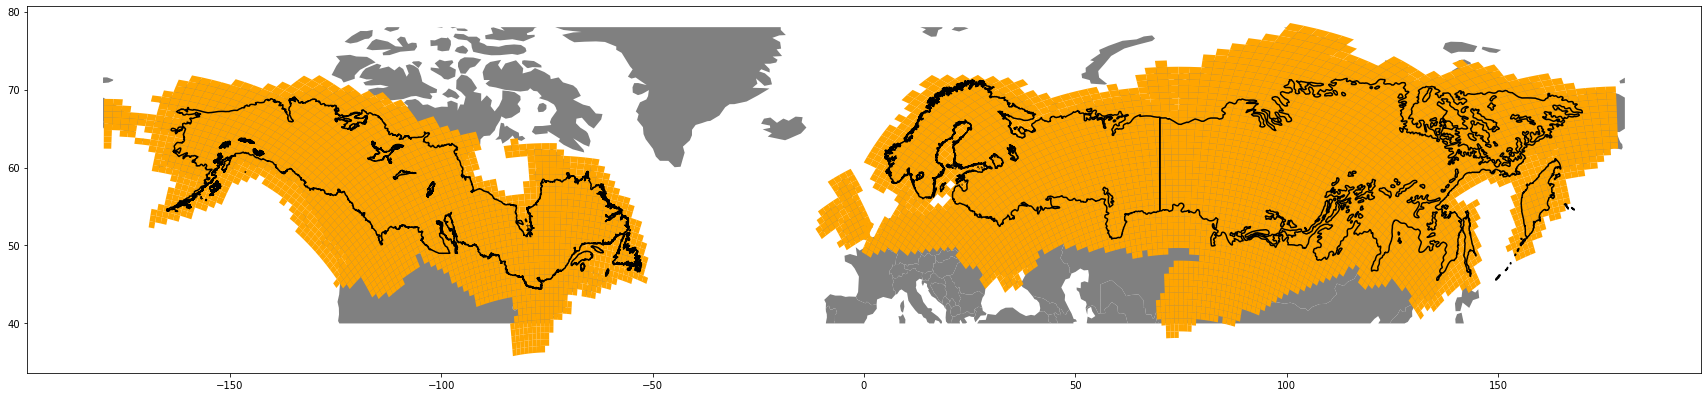

In [152]:
matplotlib.rcParams['figure.figsize'] = [30, 10]
#import importlib
#import ExtractUtils
#importlib.reload(ExtractUtils)
MAAP_VERSION_LIST = ["HLS_stack_2022_v2"]

for MAAP_VERSION in MAAP_VERSION_LIST:
    
    CURRENT_tindex_fn = f'/projects/my-public-bucket/DPS_tile_lists/HLS/fall2022/{MAAP_VERSION}/HLS_tindex_master.csv'

    HLS_mosaic_json_fn_local, CURRENT_tindex_matches_gdf = ExtractUtils.build_mosaic_json(
                               CURRENT_tindex_fn, 
                               boreal_tile_index_path = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg', 
                               BAD_TILE_LIST = BAD_TILE_LIST, 
                               cols_list = ['tile_num','s3_path','local_path'])

    HLS_mosaic_json_fn = HLS_mosaic_json_fn_local.replace('/projects/my-public-bucket', 's3://maap-ops-workspace/shared/nathanmthomas')

### Build/write a MScomp input params table

In [ ]:
%time
mscomp_params_table_fn = ExtractUtils.write_mscomp_params_table(CURRENT_tindex_fn,  
                                       MSCOMP_TYPE = 'HLS', mscomp_input_glob_str="output*context.json", mscomp_num_scenes_glob_str="master*.json", 
                                       cols_list=['in_tile_num','max_cloud','start_month_day','end_month_day','start_year','end_year'])

In [120]:
mscomp_params_table_fn = '/projects/my-public-bucket/DPS_tile_lists/HLS/fall2022/HLS_stack_2022_v2/HLS_input_params.csv'

### The original spring 2022 HLS comp run types by tile
compositing requires trial and error to return tile composites that are free from cloud and seasonal artifacts  
these "run types" show the final set of compositing params used to return the composites for each tile

In [154]:
# Prep spring2022 HLS input params table - for comparison with current runs
SPRING2022_HLS_input_param_fn = '/projects/my-public-bucket/DPS_tile_lists/HLS/spring2022/HLS_input_params.csv'
boreal_tile_index = gpd.read_file('/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg')

SPRING2022_HLS_input_params_df = pd.read_csv(SPRING2022_HLS_input_param_fn)
SPRING2022_HLS_input_params_df['run_type'] = SPRING2022_HLS_input_params_df[['max_cloud','start_month_day','end_month_day','start_year','end_year']].apply(
    lambda x: '_'.join(x.dropna().astype(str)),
    axis=1
)

# Compare CURRENT tile_index_matches_gdf with SPRING2022 params df to get MISSING

CURRENT_MISSING_TILES_GDF = boreal_tile_index[~boreal_tile_index['tile_num'].isin(CURRENT_tindex_matches_gdf.tile_num.to_list())]

CURRENT_MISSING_tindex_HLS_input_params = CURRENT_MISSING_TILES_GDF.merge(SPRING2022_HLS_input_params_df[['in_tile_num','run_type']], how='left', left_on='tile_num', right_on='in_tile_num')
#CURRENT_MISSING_tindex_HLS_input_params.plot(column='run_type', cmap = "nipy_spectral", legend=True)
CURRENT_MISSING_tindex_HLS_input_params.groupby(['run_type']).size()


INFO:fiona.ogrext:Failed to auto identify EPSG: 7


Series([], dtype: int64)

### Map missing tiles by run_name

In [ ]:
#import importlib
#importlib.reload(ExtractUtils)
ExtractUtils.plot_gdf_on_world(CURRENT_MISSING_tindex_HLS_input_params)

In [129]:
DPS_INPUT_TILE_NUM_LIST = CURRENT_MISSING_tindex_HLS_input_params[CURRENT_MISSING_tindex_HLS_input_params.run_type == '35_06-15_09-01_2019_2021'].tile_num.to_list()
DPS_INPUT_TILE_NUM_LIST

[2490]

In [50]:
DPS_INPUT_TILE_NUM_LIST = CURRENT_MISSING_tindex_HLS_input_params[CURRENT_MISSING_tindex_HLS_input_params.run_type == '50_06-15_09-01_2019_2021'].tile_num.to_list()
DPS_INPUT_TILE_NUM_LIST

[2423, 3067]

In [22]:
DPS_INPUT_TILE_NUM_LIST = CURRENT_MISSING_tindex_HLS_input_params[CURRENT_MISSING_tindex_HLS_input_params.run_type == '40_06-01_09-15_2019_2021'].tile_num.to_list()
DPS_INPUT_TILE_NUM_LIST

[3866, 37298, 38592]

### Map completed tiles by run_name

AxesSubplot(0.125,0.248028;0.775x0.508945)
AxesSubplot(0.125,0.298922;0.62x0.407156)


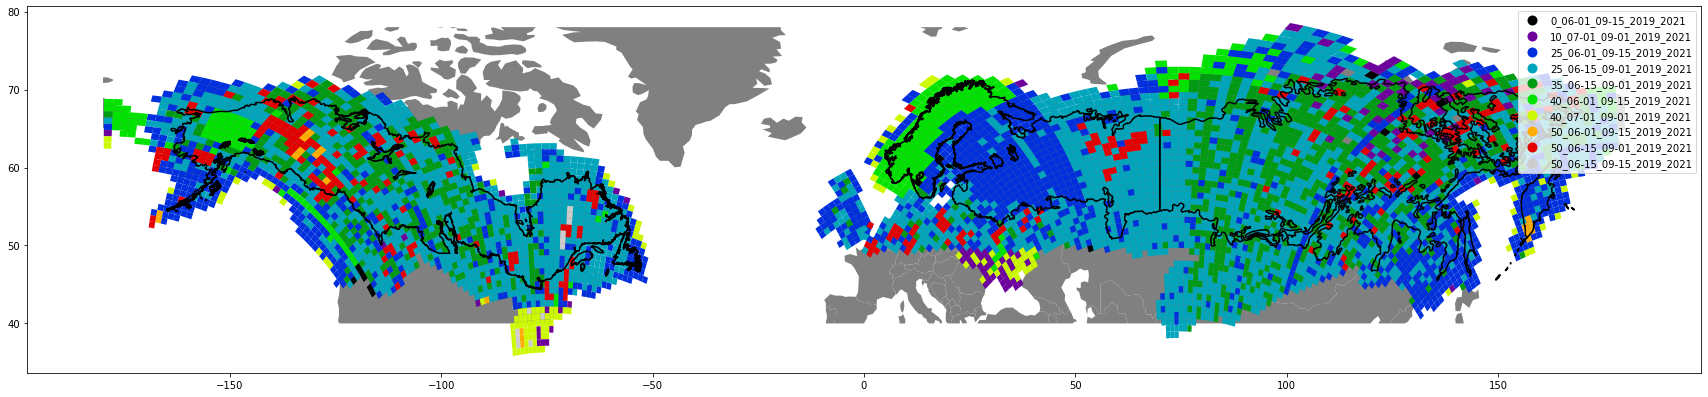

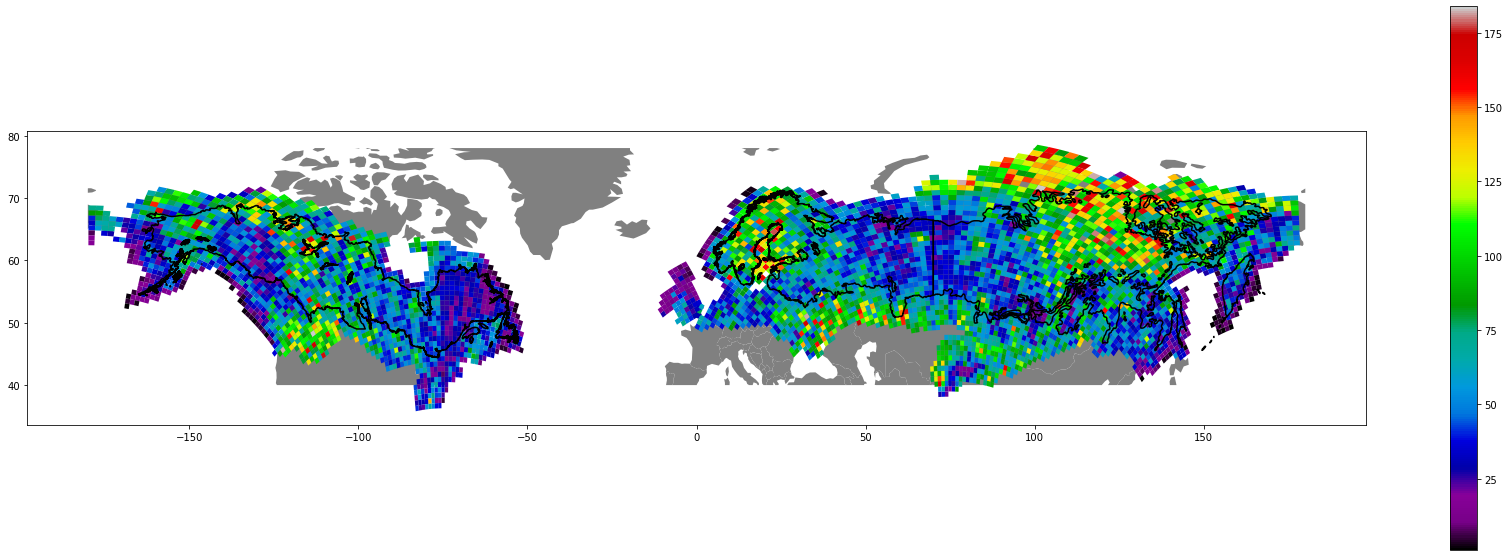

In [128]:
mscomp_params_table_fn = '/projects/my-public-bucket/DPS_tile_lists/HLS/fall2022/HLS_stack_2022_v2/HLS_input_params.csv'


CURRENT_COMPLETE_HLS_input_params_df = pd.read_csv(mscomp_params_table_fn)
CURRENT_COMPLETE_tindex_HLS_input_params = boreal_tile_index.merge(CURRENT_COMPLETE_HLS_input_params_df[['tile_num','run_type','num_scenes']], how='left', left_on='tile_num', right_on='tile_num')
#CURRENT_COMPLETE_tindex_HLS_input_params.plot(column='run_type', cmap = "nipy_spectral", legend=True)
CURRENT_COMPLETE_tindex_HLS_input_params.groupby(['run_type']).size()

ExtractUtils.plot_gdf_on_world(CURRENT_COMPLETE_tindex_HLS_input_params)
ExtractUtils.plot_gdf_on_world(CURRENT_COMPLETE_tindex_HLS_input_params, MAP_COL="num_scenes")

# View the Results with Folium

## Fall 2022

In [ ]:

# Setup the mosaic tiling
tiler_base = "https://jqsd6bqdsf.execute-api.us-west-2.amazonaws.com/" #titiler.maap-project.org
tiler_mosaic =  "".join([tiler_base, "mosaicjson/tiles/{z}/{x}/{y}"])

boreal_tile_index = gpd.read_file('/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg')
Topo_mosaic_json_fn  = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/Topo_tindex_master_mosaic.json'

maplib_folium.MAP_DPS_RESULTS(tiler_mosaic, 
                              boreal_tile_index[~boreal_tile_index['tile_num'].isin(BAD_TILE_LIST)], #bad_tiles 
                              CURRENT_COMPLETE_tindex_HLS_input_params, #boreal_tile_index[boreal_tile_index['tile_num'].isin(tile_index_matches_gdf.tile_num.to_list())], 
                              CURRENT_MISSING_tindex_HLS_input_params, #boreal_tile_index[boreal_tile_index['tile_num'].isin([4441])], 
                              MATCH_TILES_NAME='Current complete tiles',
                              CHECK_TILES_NAME='Current missing tiles',
                              mosaic_json_dict = 
                                  {     ######### PRODUCT LAYERS #######
                                        #---NASA ABoVE Aboveground Boreal Woody Biomass Density
                                        'agb_mosaic_json_s3_fn': None, # AGB_mosaic_json_fn,                                                           # < -- v. spring 2022 - bad overviews, but faster
                                        #'agb_mosaic_json_s3_fn': 's3://maap-ops-workspace/shared/nathanthomas/06/AGB_tindex_master_mosaic.json',# < -- v. summer 2022 - locally corrected overviews
                                        'topo_mosaic_json_s3_fn':   Topo_mosaic_json_fn,
                                        #'mscomp_mosaic_json_s3_fn': HLS_mosaic_json_fn_spring2022, 
                                        'mscomp_mosaic_json_s3_fn': HLS_mosaic_json_fn,
                                        'worldcover_json_s3_fn': None,
                                        'tp_standage2020_json_s3_fn': None,
                                        'tp_tcc2020_json_s3_fn': None,
                                        'tp_tcc2020slope_json_s3_fn': None,
                                        'tp_tcc2020pvalue_json_s3_fn': None 
                                     },
                            #MS_BANDNAME = 'NDVI',
                            MS_BANDNAME = 'NBR2',
                            MS_BANDMIN=0.25 ,
                            MS_BANDMAX=0.45 ,
                            #MS_BANDNUM=9, 
                            MS_BANDNUM=13, 
                            MS_BANDCOLORBAR='nipy_spectral',
                              map_width=1500, map_height=750
                             )

In [ ]:
#importlib.reload(maplib_folium)
maplib_folium.map_tile_n_scenes(tindex_master_fn='/projects/my-public-bucket/DPS_tile_lists/HLS/fall2022/HLS_stack_2022_v2/HLS_input_params.csv', max_n_obs=125, map_width=1500, map_height=300)